In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from ipywidgets import interact, fixed, IntSlider, Checkbox
from pathlib import Path
# Instalamos el paquete de utilidades
%pip install -qq git+https://github.com/udesa-vision/i308-utils.git

from i308_utils import imshow, show_images
from utils import rectify_stereo_pair, draw_epipolar_lines, show_pair_any, compute_depth

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Cargamos los archivos y analizamos el contenido
with open('data/pkls/stereo_calibration.pkl', 'rb') as f:
    calib = pickle.load(f)

with open('data/pkls/stereo_maps.pkl', 'rb') as f:
    maps = pickle.load(f)

print('Calibration keys:', calib.keys())
print('Maps keys:', maps.keys())

Calibration keys: dict_keys(['left_K', 'left_dist', 'right_K', 'right_dist', 'R', 'T', 'E', 'F', 'image_size'])
Maps keys: dict_keys(['left_map_x', 'left_map_y', 'right_map_x', 'right_map_y', 'R1', 'R2', 'P1', 'P2', 'Q', 'validRoi1', 'validRoi2'])


Pares rectificados: 23


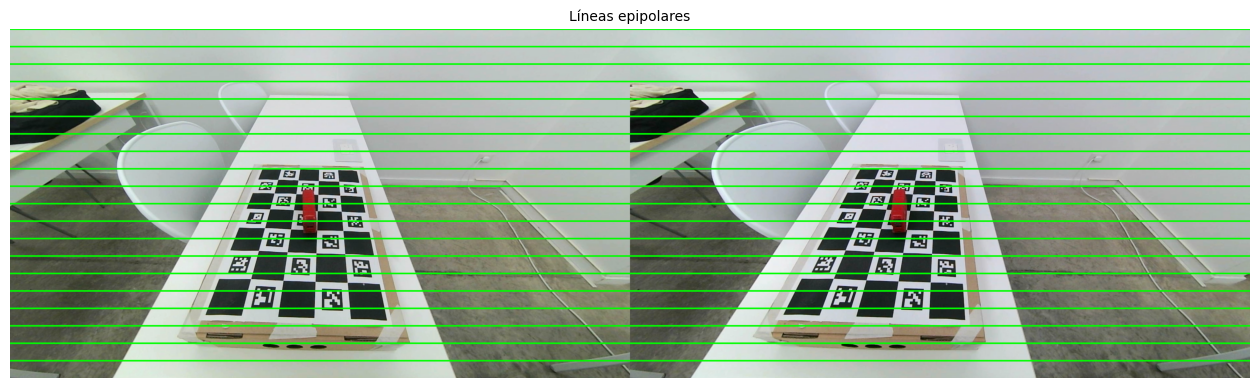

In [3]:
# Rectificamos los pares estéreo
in_dir = Path('data/captures')
out_dir = Path('data/rectified')
out_dir.mkdir(exist_ok=True)

indices = list(range(14, 37))

procesados = 0
faltantes = []

for i in indices:
    left_path = in_dir / f'left_{i}.jpg'
    right_path = in_dir / f'right_{i}.jpg'
    if not left_path.exists() or not right_path.exists():
        faltantes.append(i)
        continue

    rectL, rectR = rectify_stereo_pair(str(left_path), str(right_path), maps)

    # Guardar
    cv2.imwrite(str(out_dir / f'rect_left_{i}.jpg'), rectL)
    cv2.imwrite(str(out_dir / f'rect_right_{i}.jpg'), rectR)
    procesados += 1

print(f'Pares rectificados: {procesados}')
if faltantes:
    print('Índices faltantes:', faltantes)

# Visualizamos un par de imágenes rectificadas con líneas epipolares
combinados = draw_epipolar_lines(rectL, rectR)
imshow(combinados, title='Líneas epipolares', figsize=(16, 8))

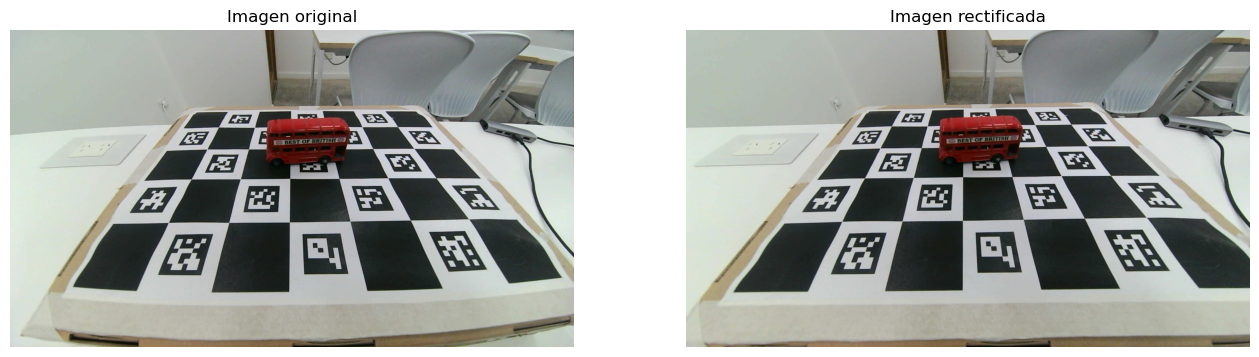

In [4]:
imgL = cv2.imread('data/captures/left_14.jpg')
rectifiedL = cv2.remap(imgL, maps['left_map_x'], maps['left_map_y'], cv2.INTER_LINEAR)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('Imagen original')
plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Imagen rectificada')
plt.imshow(cv2.cvtColor(rectifiedL, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [5]:
idx_slider = IntSlider(min=14, max=37, step=1, value=14, layout={'width': '900px'})
lines_slider = IntSlider(min=5, max=50, step=5, value=20, layout={'width': '400px'})

interact(
    show_pair_any,
    idx=idx_slider,
    draw_lines=Checkbox(value=True, description='Rectificar'),
    num_lines=lines_slider,
    stereo_maps=fixed(maps)
)

interactive(children=(IntSlider(value=14, description='idx', layout=Layout(width='900px'), max=37, min=14), Ch…

<function utils.show_pair_any(idx=14, rectificar=True, num_lines=20, stereo_maps=None)>

## Cálculo de Disparidad
### Block Matching

In [6]:
from pathlib import Path

# Crear carpeta de salida (si no existe)
out_dir = Path("../out/disparities_bm")
out_dir.mkdir(exist_ok=True)

# Rango de índices (ajustá si tus nombres empiezan en otro número)
indices = range(14, 38)

for i in indices:
    left_path  = f"data/captures/left_{i}.jpg"
    right_path = f"data/captures/right_{i}.jpg"
    if not Path(left_path).exists() or not Path(right_path).exists():
        print(f"Saltando par {i}: faltan imágenes.")
        continue

    # Rectificación (usando tu función)
    rectL, rectR = rectify_stereo_pair(left_path, right_path, maps)

    # Pasar a escala de grises
    rectL_gray = cv2.cvtColor(rectL, cv2.COLOR_BGR2GRAY)
    rectR_gray = cv2.cvtColor(rectR, cv2.COLOR_BGR2GRAY)

    # Configurar el StereoBM
    stereo_bm = cv2.StereoBM_create(numDisparities=256, blockSize=15)
    stereo_bm.setPreFilterSize(31)
    stereo_bm.setPreFilterCap(15)
    stereo_bm.setMinDisparity(0)
    stereo_bm.setTextureThreshold(7)
    stereo_bm.setUniquenessRatio(3)
    stereo_bm.setSpeckleWindowSize(512)
    stereo_bm.setSpeckleRange(32)
    stereo_bm.setDisp12MaxDiff(23)

    # Calcular mapa de disparidad
    disparity_map_bm = stereo_bm.compute(rectL_gray, rectR_gray).astype(np.float32) / 16.0

    # Guardar disparidad normalizada para visualización
    disp_vis = cv2.normalize(disparity_map_bm, None, 0, 255, cv2.NORM_MINMAX)
    disp_vis = np.uint8(disp_vis)
    cv2.imwrite(str(out_dir / f"disp_bm_{i}.png"), disp_vis)

    print(f"→ Procesado par {i}: disparidad guardada en {out_dir}/disp_bm_{i}.png")


→ Procesado par 14: disparidad guardada en ../out/disparities_bm/disp_bm_14.png
→ Procesado par 15: disparidad guardada en ../out/disparities_bm/disp_bm_15.png
→ Procesado par 16: disparidad guardada en ../out/disparities_bm/disp_bm_16.png
→ Procesado par 17: disparidad guardada en ../out/disparities_bm/disp_bm_17.png
→ Procesado par 18: disparidad guardada en ../out/disparities_bm/disp_bm_18.png
→ Procesado par 19: disparidad guardada en ../out/disparities_bm/disp_bm_19.png
→ Procesado par 20: disparidad guardada en ../out/disparities_bm/disp_bm_20.png
→ Procesado par 21: disparidad guardada en ../out/disparities_bm/disp_bm_21.png
→ Procesado par 22: disparidad guardada en ../out/disparities_bm/disp_bm_22.png
→ Procesado par 23: disparidad guardada en ../out/disparities_bm/disp_bm_23.png
→ Procesado par 24: disparidad guardada en ../out/disparities_bm/disp_bm_24.png
→ Procesado par 25: disparidad guardada en ../out/disparities_bm/disp_bm_25.png
→ Procesado par 26: disparidad guardada 

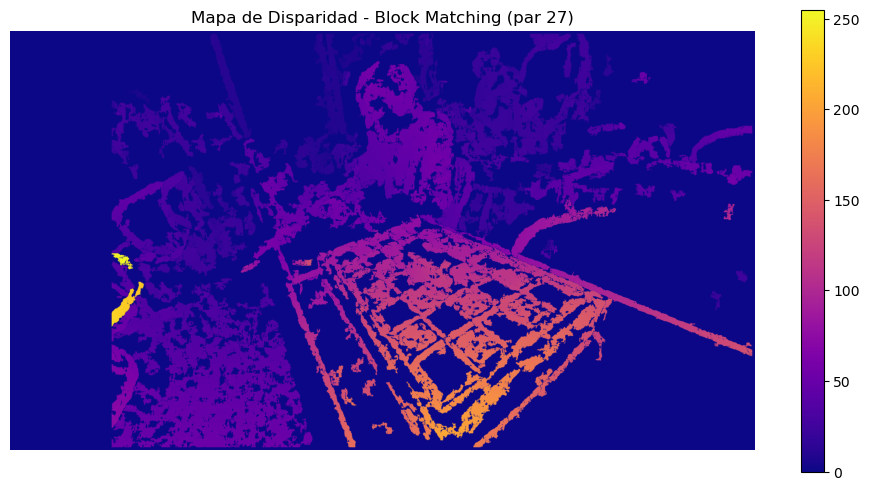

In [7]:
# Mostrar uno de ejemplo
idx_show = 27
disp_show = cv2.imread(str(out_dir / f"disp_bm_{idx_show}.png"), cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12,6))
plt.imshow(disp_show, cmap='plasma')
plt.colorbar()
plt.title(f'Mapa de Disparidad - Block Matching (par {idx_show})')
plt.axis('off')
plt.show()

### Semi-Global Block Matching

In [8]:
# Carpeta de salida
out_dir = Path("../out/disparities_sgbm")
out_dir.mkdir(exist_ok=True)

# Rango de imágenes (14..37)
indices = range(14, 38)

for i in indices:
    left_path  = f"data/captures/left_{i}.jpg"
    right_path = f"data/captures/right_{i}.jpg"
    if not Path(left_path).exists() or not Path(right_path).exists():
        print(f"Saltando par {i}: faltan imágenes.")
        continue

    # Rectificación estéreo
    rectL, rectR = rectify_stereo_pair(left_path, right_path, maps)

    # Pasar a escala de grises
    rectL_gray = cv2.cvtColor(rectL, cv2.COLOR_BGR2GRAY)
    rectR_gray = cv2.cvtColor(rectR, cv2.COLOR_BGR2GRAY)

    # --- Configuración StereoSGBM (con tus parámetros) ---
    stereo_sgbm = cv2.StereoSGBM_create(
        numDisparities=128,
        blockSize=7
    )

    stereo_sgbm.setP1(16)
    stereo_sgbm.setP2(128)
    stereo_sgbm.setUniquenessRatio(7)
    stereo_sgbm.setSpeckleWindowSize(512)
    stereo_sgbm.setSpeckleRange(64)
    stereo_sgbm.setDisp12MaxDiff(1)
    stereo_sgbm.setPreFilterCap(63)

    # --- Calcular disparidad ---
    disparity_map = stereo_sgbm.compute(rectL_gray, rectR_gray).astype(np.float32) / 16.0

    # --- Guardar mapa normalizado ---
    disp_vis = cv2.normalize(disparity_map, None, 0, 255, cv2.NORM_MINMAX)
    disp_vis = np.uint8(disp_vis)
    cv2.imwrite(str(out_dir / f"disp_sgbm_{i}.png"), disp_vis)

    print(f"→ Procesado par {i}: disparidad guardada en {out_dir}/disp_sgbm_{i}.png")

→ Procesado par 14: disparidad guardada en ../out/disparities_sgbm/disp_sgbm_14.png
→ Procesado par 15: disparidad guardada en ../out/disparities_sgbm/disp_sgbm_15.png
→ Procesado par 16: disparidad guardada en ../out/disparities_sgbm/disp_sgbm_16.png
→ Procesado par 17: disparidad guardada en ../out/disparities_sgbm/disp_sgbm_17.png
→ Procesado par 18: disparidad guardada en ../out/disparities_sgbm/disp_sgbm_18.png
→ Procesado par 19: disparidad guardada en ../out/disparities_sgbm/disp_sgbm_19.png
→ Procesado par 20: disparidad guardada en ../out/disparities_sgbm/disp_sgbm_20.png
→ Procesado par 21: disparidad guardada en ../out/disparities_sgbm/disp_sgbm_21.png
→ Procesado par 22: disparidad guardada en ../out/disparities_sgbm/disp_sgbm_22.png
→ Procesado par 23: disparidad guardada en ../out/disparities_sgbm/disp_sgbm_23.png
→ Procesado par 24: disparidad guardada en ../out/disparities_sgbm/disp_sgbm_24.png
→ Procesado par 25: disparidad guardada en ../out/disparities_sgbm/disp_sgbm

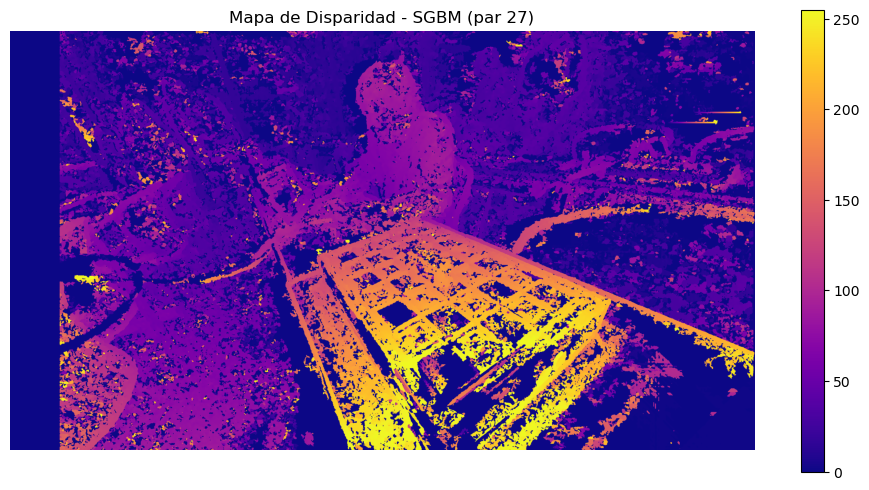

In [9]:
# --- Visualizar uno de ejemplo ---
idx_show = 27
disp_show = cv2.imread(str(out_dir / f"disp_sgbm_{idx_show}.png"), cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12,6))
plt.imshow(disp_show, cmap='plasma')
plt.colorbar()
plt.title(f'Mapa de Disparidad - SGBM (par {idx_show})')
plt.axis('off')
plt.show()


### Cre Stereo

In [10]:
%pip install -qq onnxruntime

Note: you may need to restart the kernel to use updated packages.


In [11]:
width, height = rectL_gray.shape[1], rectL_gray.shape[0]

fx = calib['left_K'][0][0]
fy = calib['left_K'][1][1]
cx0 = calib['left_K'][0][2]
cy0 = calib['left_K'][1][2]

# baseline = np.linalg.norm(calib['T'])  # Distancia entre cámaras

In [12]:
from disparity.methods import Calibration, InputPair, Config
from disparity.method_cre_stereo import CREStereo

# carpeta de salida
out_dir = Path("../out/disparities_cre")
out_dir.mkdir(exist_ok=True)

# baseline entre cámaras
baseline = np.linalg.norm(calib['T'])

# preparar modelo CRE Stereo (se crea una vez y se reutiliza)
models_path = Path("models")
models_path.mkdir(exist_ok=True)

config = Config(models_path=models_path)
cre_stereo = CREStereo(config)

# seteo de parámetros del modelo tal como lo tenías
cre_stereo.parameters['Shape'].set_value('1280x720')

# rango de índices a procesar
indices = range(14, 19)

for i in indices:
    left_path  = f"data/captures/left_{i}.jpg"
    right_path = f"data/captures/right_{i}.jpg"
    if not Path(left_path).exists() or not Path(right_path).exists():
        print(f"Saltando par {i}: faltan imágenes.")
        continue

    # 1. Rectificación estéreo usando tus mapas
    rectL, rectR = rectify_stereo_pair(left_path, right_path, maps)

    # 2. Pasar a escala de grises (CRE Stereo trabaja con intensidad, igual que SGBM)
    rectL_gray = cv2.cvtColor(rectL, cv2.COLOR_BGR2GRAY)
    rectR_gray = cv2.cvtColor(rectR, cv2.COLOR_BGR2GRAY)

    # 3. Armar la calibración para ESTE par (usa tamaño real de la imagen rectificada)
    height, width = rectL_gray.shape[:2]

    fx  = calib['left_K'][0][0]
    fy  = calib['left_K'][1][1]
    cx0 = calib['left_K'][0][2]
    cy0 = calib['left_K'][1][2]

    # cx1 = cx0 as in tu código original
    calibration = Calibration(**{
        "width": width,
        "height": height,
        "baseline_meters": baseline / 1000,  # mismo que vos
        "fx": fx,
        "fy": fy,
        "cx0": cx0,
        "cx1": cx0,
        "cy": cy0,
        "depth_range": [0.05, 20.0],
        "left_image_rect_normalized": [0, 0, 1, 1]
    })

    # 4. Empaquetar el par para CRE Stereo
    pair = InputPair(
        left_image=rectL_gray,
        right_image=rectR_gray,
        calibration=calibration
    )

    # 5. Correr CRE Stereo para ese par
    disparity_map_cs = cre_stereo.compute_disparity(pair)

    # `disparity_map_cs.disparity_pixels` es la disparidad estimada en píxeles
    disp_cs = disparity_map_cs.disparity_pixels.astype(np.float32)

    # 6. Guardar versión visual normalizada (0-255)
    disp_vis = cv2.normalize(disp_cs, None, 0, 255, cv2.NORM_MINMAX)
    disp_vis = np.uint8(disp_vis)
    cv2.imwrite(str(out_dir / f"disp_cre_{i}.png"), disp_vis)

    print(f"→ Procesado par {i}: disparidad CRE guardada en {out_dir}/disp_cre_{i}.png")


models/crestereo_combined_iter5_720x1280.onnx


/opt/anaconda3/envs/cv/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CoreMLExecutionProvider, AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


→ Procesado par 14: disparidad CRE guardada en ../out/disparities_cre/disp_cre_14.png
models/crestereo_combined_iter5_720x1280.onnx
→ Procesado par 15: disparidad CRE guardada en ../out/disparities_cre/disp_cre_15.png
models/crestereo_combined_iter5_720x1280.onnx
→ Procesado par 16: disparidad CRE guardada en ../out/disparities_cre/disp_cre_16.png
models/crestereo_combined_iter5_720x1280.onnx
→ Procesado par 17: disparidad CRE guardada en ../out/disparities_cre/disp_cre_17.png
models/crestereo_combined_iter5_720x1280.onnx
→ Procesado par 18: disparidad CRE guardada en ../out/disparities_cre/disp_cre_18.png


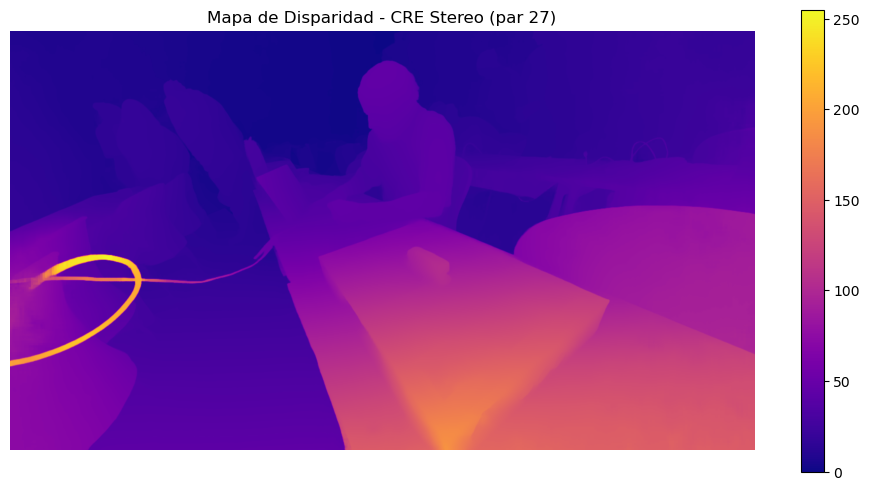

In [13]:
# 7. Mostrar uno de ejemplo
idx_show = 27
disp_show = cv2.imread(str(out_dir / f"disp_cre_{idx_show}.png"), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12, 6))
plt.imshow(disp_show, cmap='plasma')
plt.colorbar()
plt.title(f'Mapa de Disparidad - CRE Stereo (par {idx_show})')
plt.axis('off')
plt.show()

### Cálculo de Profundidad

Usamos la fórmula:
$ z = \frac{f . B}{d} $

In [14]:
# carpeta de entrada (disparidades CRE)
disp_dir = Path("../out/disparities_cre")
out_dir = Path("../out/depth_maps_cre")
out_dir.mkdir(exist_ok=True)

# baseline y focal de la cámara izquierda
B = np.linalg.norm(calib['T'])  # baseline (en las mismas unidades que usaste en calibración)
f = calib['left_K'][0][0]       # focal en píxeles

# rango de imágenes
indices = range(14, 19)

for i in indices:
    disp_path = disp_dir / f"disp_cre_{i}.png"
    if not disp_path.exists():
        print(f"Saltando par {i}: no se encontró el mapa de disparidad CRE.")
        continue

    # leer disparidad en float
    disparity_map = cv2.imread(str(disp_path), cv2.IMREAD_UNCHANGED).astype(np.float32)

    # escalar a rango real si fue guardado normalizado (0–255)
    # si tus disparidades CRE originales ya estaban en píxeles reales, sacá este paso
    disparity_map = disparity_map / 255.0 * np.nanmax(disparity_map)

    # calcular profundidad
    depth_map = compute_depth(disparity_map, f, B)

    # guardar versión visual (normalizada para que se vea bien)
    depth_vis = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    depth_vis = np.uint8(depth_vis)
    cv2.imwrite(str(out_dir / f"depth_cre_{i}.png"), depth_vis)

    print(f"→ Procesado par {i}: mapa de profundidad guardado en {out_dir}/depth_cre_{i}.png")


→ Procesado par 14: mapa de profundidad guardado en ../out/depth_maps_cre/depth_cre_14.png
→ Procesado par 15: mapa de profundidad guardado en ../out/depth_maps_cre/depth_cre_15.png
→ Procesado par 16: mapa de profundidad guardado en ../out/depth_maps_cre/depth_cre_16.png
→ Procesado par 17: mapa de profundidad guardado en ../out/depth_maps_cre/depth_cre_17.png
→ Procesado par 18: mapa de profundidad guardado en ../out/depth_maps_cre/depth_cre_18.png


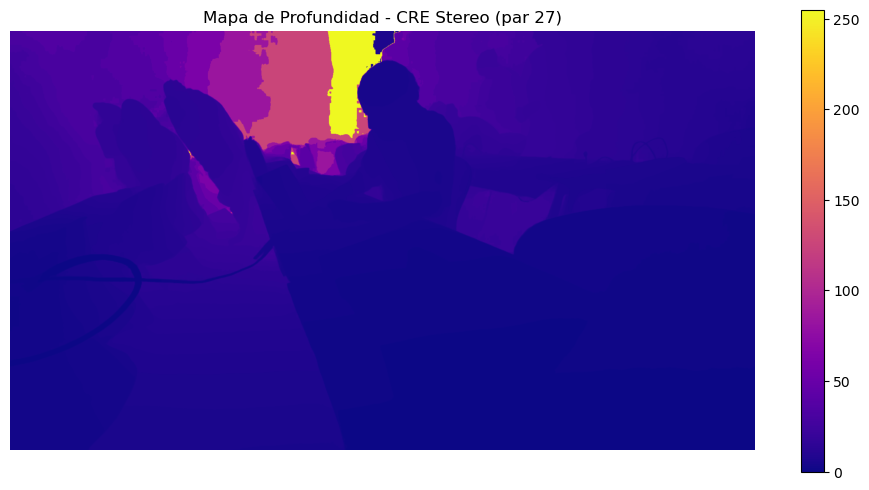

In [15]:
# --- Mostrar uno de ejemplo ---
idx_show = 27
depth_show = cv2.imread(str(out_dir / f"depth_cre_{idx_show}.png"), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12,6))
plt.imshow(depth_show, cmap='plasma')
plt.colorbar()
plt.title(f"Mapa de Profundidad - CRE Stereo (par {idx_show})")
plt.axis('off')
plt.show()

In [16]:
# Carpeta de entrada (mapas de profundidad originales)
depth_dir = Path("../out/depth_maps_cre")
# Carpeta de salida (mapas recortados)
out_dir = Path("../out/depth_maps_cre_clipped")
out_dir.mkdir(exist_ok=True)

# Rango de pares
indices = range(14, 19)

for i in indices:
    depth_path = depth_dir / f"depth_cre_{i}.png"
    if not depth_path.exists():
        print(f"Saltando par {i}: no se encontró el mapa de profundidad.")
        continue

    # Leer el mapa de profundidad en float
    depth_map = cv2.imread(str(depth_path), cv2.IMREAD_UNCHANGED).astype(np.float32)

    # --- Recorte: limitar profundidades mayores a 10000 ---
    depth_map_clipped = depth_map.copy()
    depth_map_clipped[depth_map_clipped > 10] = 10

    # Guardar visualización normalizada (0–255)
    depth_vis = cv2.normalize(depth_map_clipped, None, 0, 255, cv2.NORM_MINMAX)
    depth_vis = np.uint8(depth_vis)
    cv2.imwrite(str(out_dir / f"depth_cre_clipped_{i}.png"), depth_vis)

    print(f"→ Procesado par {i}: mapa de profundidad recortado guardado en {out_dir}/depth_cre_clipped_{i}.png")

→ Procesado par 14: mapa de profundidad recortado guardado en ../out/depth_maps_cre_clipped/depth_cre_clipped_14.png
→ Procesado par 15: mapa de profundidad recortado guardado en ../out/depth_maps_cre_clipped/depth_cre_clipped_15.png
→ Procesado par 16: mapa de profundidad recortado guardado en ../out/depth_maps_cre_clipped/depth_cre_clipped_16.png
→ Procesado par 17: mapa de profundidad recortado guardado en ../out/depth_maps_cre_clipped/depth_cre_clipped_17.png
→ Procesado par 18: mapa de profundidad recortado guardado en ../out/depth_maps_cre_clipped/depth_cre_clipped_18.png


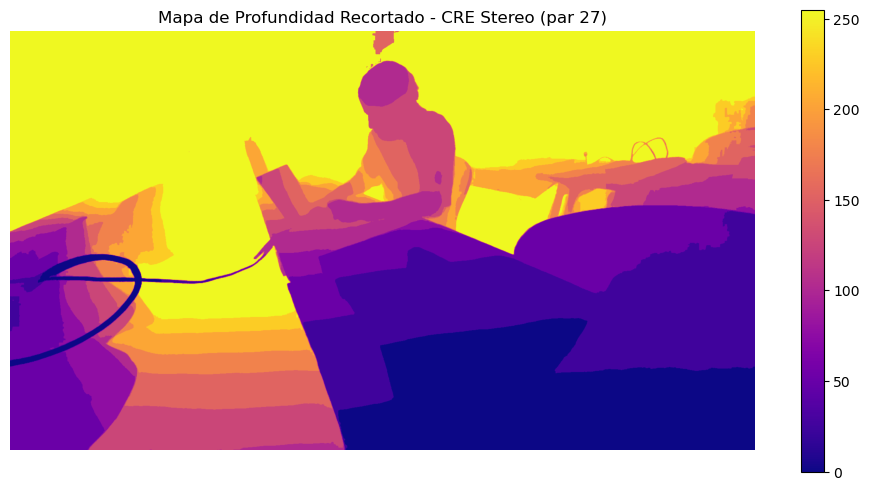

In [17]:
# --- Mostrar uno de ejemplo ---
idx_show = 27  # Cambiá este índice para ver otro par
depth_show = cv2.imread(str(out_dir / f"depth_cre_clipped_{idx_show}.png"), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12,6))
plt.imshow(depth_show, cmap='plasma')
plt.colorbar()
plt.title(f"Mapa de Profundidad Recortado - CRE Stereo (par {idx_show})")
plt.axis('off')
plt.show()

In [ ]:
# ### Intento de reconstrucción 3D desde mapas de profundidad CRE recortados ###

# # === Carpetas de entrada/salida ===
# depth_dir = Path("../out/depth_maps_cre_clipped")
# ply_dir = Path("../out/clouds_cre")
# ply_dir.mkdir(exist_ok=True)

# indices = range(14, 19)

# # --- Parámetros de cámara ---
# K = calib['left_K']              # matriz intrínseca
# fx = K[0, 0]
# fy = K[1, 1]
# cx = K[0, 2]
# cy = K[1, 2]

# # Matriz de proyección (simplificada)
# # Usamos las intrínsecas para pasar de (u,v,depth) → XYZ
# def depth_to_points(depth_map, K):
#     """Convierte mapa de profundidad a puntos 3D en el marco de la cámara."""
#     h, w = depth_map.shape
#     i, j = np.meshgrid(np.arange(w), np.arange(h))
#     Z = depth_map
#     X = (i - K[0, 2]) * Z / K[0, 0]
#     Y = (j - K[1, 2]) * Z / K[1, 1]
#     points = np.stack((X, Y, Z), axis=-1)
#     return points

# # --- Guardar nube PLY ---
# def save_ply(points, colors, filename):
#     """Guarda puntos XYZ y colores RGB en formato .ply."""
#     mask = np.isfinite(points[..., 2]) & (points[..., 2] > 0)
#     pts = points[mask]
#     cols = colors[mask]
#     with open(filename, 'w') as f:
#         f.write('ply\nformat ascii 1.0\n')
#         f.write(f'element vertex {len(pts)}\n')
#         f.write('property float x\nproperty float y\nproperty float z\n')
#         f.write('property uchar red\nproperty uchar green\nproperty uchar blue\n')
#         f.write('end_header\n')
#         for (x,y,z),(r,g,b) in zip(pts, cols):
#             f.write(f"{x} {y} {z} {int(r)} {int(g)} {int(b)}\n")

# # --- Loop principal ---
# for i in indices:
#     depth_path = depth_dir / f"depth_cre_clipped_{i}.png"
#     left_path  = f"data/captures/left_{i}.jpg"
#     right_path = f"data/captures/right_{i}.jpg"

#     if not depth_path.exists() or not Path(left_path).exists():
#         print(f"Saltando par {i}: falta depth o imagen.")
#         continue

#     # Cargar profundidad (en uint8 visual), escalar a rango real aproximado
#     depth_vis = cv2.imread(str(depth_path), cv2.IMREAD_UNCHANGED).astype(np.float32)
#     depth = cv2.normalize(depth_vis, None, 0, 10000, cv2.NORM_MINMAX)  # rango de 0–10000 aprox

#     # Cargar color rectificado (para textura)
#     rectL, rectR = rectify_stereo_pair(left_path, right_path, maps)
#     color = cv2.cvtColor(rectL, cv2.COLOR_BGR2RGB) / 255.0  # normalizar 0–1

#     # Generar nube
#     points3D = depth_to_points(depth, K)
#     save_ply(points3D, (color * 255).astype(np.uint8), ply_dir / f"bus_{i}.ply")

#     print(f"→ Nube 3D guardada: {ply_dir}/bus_{i}.ply")

# print("✅ Reconstrucción 3D completa. Podés abrir los .ply en Meshlab o CloudCompare.")


→ Nube 3D guardada: ../out/clouds_cre/bus_14.ply
→ Nube 3D guardada: ../out/clouds_cre/bus_15.ply
→ Nube 3D guardada: ../out/clouds_cre/bus_16.ply
→ Nube 3D guardada: ../out/clouds_cre/bus_17.ply
→ Nube 3D guardada: ../out/clouds_cre/bus_18.ply
✅ Reconstrucción 3D completa. Podés abrir los .ply en Meshlab o CloudCompare.
